In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import spotipy #https://spotipy.readthedocs.io/en/2.22.1/
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import statsmodels.api as sm #https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

## 1. Conexión con la API

In [ ]:
#Cargamos las credenciales
load_dotenv(".env")
client_id=os.environ.get("CLIENT_ID")
client_secret=os.environ.get("CLIENT_SECRET")

In [3]:
#Realizamos la conexión con la API y cargamos las canciones mas destacadas
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
spotify = spotipy.Spotify(auth_manager=auth_manager)
top_songs=spotify.artist_top_tracks("5Uox3n7m4W2CoM9MmHPJwQ")

El metodo artist_top_tracks nos devuelve un json que contiene informacion sobre las 10 mejores canciones del artista y está organizado de la siguiente forma:

- "tracks":
    
    *album*:

        'album_type', 'artists', 'available_markets', 'external_urls', 'href', 'id', 'images', 'is_playable', 'name', 'release_date', 'release_date_precision', 'total_tracks', 'type', 'uri'
    
    *artist*: 
    
        'external_urls', 'href', 'id', 'name', 'type', 'uri'
        
    *available_markets*: mercados en los que está disponible la canción

    *disc_number*: numero del disco

    *duration_ms*: duracion de la cancion en milisegundos (segundos/1000)

    *explicit*: contenido explicito

    *external_urls*: url de la cancion

    *name*: nombre de la cancion

    *popularity*: indice de popularidad (0-100)

    *track_number*: orden de aparicion en el album


## 2. Tratamiento de datos

Pasaremos la siguiente información relevante a un df: 

- Columnas album

     - nombre_album
     - fecha_album

- Columnas artistas

     - artista_1
     - artista_2
     - artista_3

- Columna duracion (milisegundos)

- Columna lenguaje explicito

- Columna nombre de la cancion

- Columna popularity (0-100, como de popular es la cancion con respecto a otras de la plataforma)


In [5]:
data=pd.DataFrame()
#nombre de la cancion
data["cancion"]=pd.json_normalize(top_songs["tracks"])["name"]
#duracion en min y seg
data["duracion_min"]=round(pd.json_normalize(top_songs["tracks"])["duration_ms"]/1000/60,2)
data["duracion_seg"]=round(pd.json_normalize(top_songs["tracks"])["duration_ms"]/1000,2)
#popularidad
data["popularidad"]=pd.json_normalize(top_songs["tracks"])["popularity"]
#artistas
data["artista_1"]=None
data["artista_2"]=None
data["artista_3"]=None

for canc, index in zip(pd.json_normalize(top_songs["tracks"])["artists"], range(10)):
    # Añadir primer artista (siempre existe)
    data.loc[index,"artista_1"]=canc[0]["name"]
        
    # Añadir segundo artista si existe, si no "NaN"
    data.loc[index,"artista_2"]=canc[1]["name"] if len(canc) > 1 else "NaN"
        
    # Añadir tercer artista si existe, si no "NaN"
    data.loc[index,"artista_3"]=canc[2]["name"] if len(canc) > 2 else "NaN"

#contenido explicito
data["explicito"]=pd.json_normalize(top_songs["tracks"])["explicit"]
#nombre del album
data["nombre_album"]=pd.json_normalize(top_songs["tracks"])["album.name"]
#fecha del album
data["fecha_album"]=pd.json_normalize(top_songs["tracks"])["album.release_date"]
#RESULTADO
data

,cancion,duracion_min,duracion_seg,popularidad,artista_1,artista_2,artista_3,explicito,nombre_album,fecha_album
0,Still Luvin,4.12,246.97,72,Delaossa,Quevedo,Bigla The Kid,False,La Madrugá,2025-03-20
1,El Patio,3.88,232.64,67,Pepe y Vizio,Delaossa,KIDDO,False,El Patio,2022-07-15
2,Veneno,4.31,258.59,64,Delaossa,KIDDO,J.Moods,False,La Tour Liffee,2020-06-04
3,Lejos,3.38,202.58,59,Delaossa,Cruz Cafuné,Gese Da O,False,Lejos,2020-03-24
4,La Placita,3.80,228.29,58,Delaossa,EAZYBOI,J.Moods,False,La Placita,2019-07-19
5,Flores,3.15,188.86,57,Delaossa,NaN,NaN,False,Flores,2025-09-17
6,Nueva Season,3.79,227.50,55,Delaossa,NaN,NaN,True,La Madrugá,2025-03-20
7,Ojos Verdes,3.18,190.59,56,Delaossa,NaN,NaN,False,Ojos Verdes,2021-09-29
8,2 The Sky,2.47,148.00,56,Delaossa,NaN,NaN,True,La Madrugá,2025-03-20
9,Demonios De Blanco,3.30,198.11,55,Delaossa,Recycled J,NaN,False,La Madrugá,2025-03-20


## 3. Relación Popularidad-Duracion

El indice de popularidad mide cuan popular es una canción frente a otras con características similares, tomando valores desde 0 (poco popular) a 100 (muy popular).

Fuente: https://www.submithub.com/story/spotify-popularity-score-guide

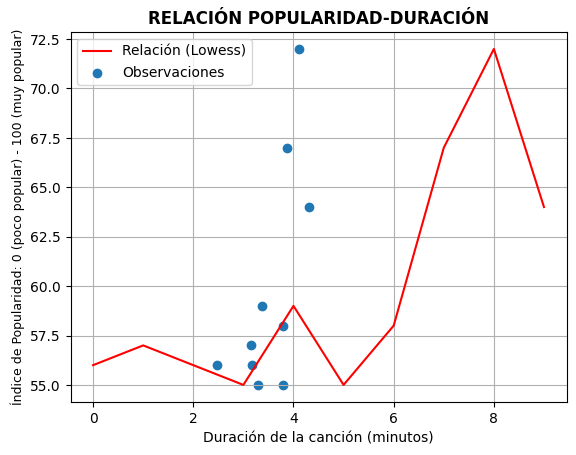

In [6]:
lowess=sm.nonparametric.lowess
y=lowess(data["popularidad"], data["duracion_min"], frac=1/10)

plt.plot(y[:,1], color="r", label="Relación (Lowess)")
plt.scatter(data["duracion_min"], data["popularidad"], label="Observaciones")
plt.title("Relación Popularidad-Duración".upper(), fontweight="bold")
plt.xlabel("Duración de la canción (minutos)")
plt.ylabel("Índice de Popularidad: 0 (poco popular) - 100 (muy popular)", size=9)
plt.legend()
plt.grid()
plt.show()